In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

from scipy.stats import shapiro

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot, add_constant
from statsmodels.formula.api import ols

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
# import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
from matplotlib import font_manager,rc
font_path = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

   Unnamed: 0       결제수단   공급원가  교환구분  네이버 포인트                   배송번호 배송비 정보  \
0           0      무통장입금  44550  교환안함        0  D-20181227-0000648-00     무료   
1          20      무통장입금  44550  교환안함        0  D-20181231-0000373-00     무료   
2          39         카드  44550  교환안함        0  D-20190101-0000038-02     무료   
3          66         카드  44550  교환안함        0  D-20190101-0000202-00     무료   
4          69  적립금,무통장입금  44550  교환안함        0  D-20190102-0000025-00     무료   

                배송시작일               배송완료일  사용한 적립금액  ...        주문자ID 카드사  \
0  2019-01-07 오전 8:56  2019-01-11 오전 5:32         0  ...        pp683  기타   
1  2019-01-03 오전 9:30  2019-01-07 오전 5:32         0  ...        pp024  기타   
2  2019-01-03 오전 9:30  2019-01-07 오전 5:32         0  ...  998948808@k  현대   
3  2019-01-03 오전 9:28  2019-01-07 오전 5:32         0  ...      nogiyaa  현대   
4  2019-01-03 오전 9:28  2019-01-07 오전 5:32     30000  ...  pyeongchan9  기타   

   쿠폰 할인금액    판매가   품목번호    주문년월    주문분기                

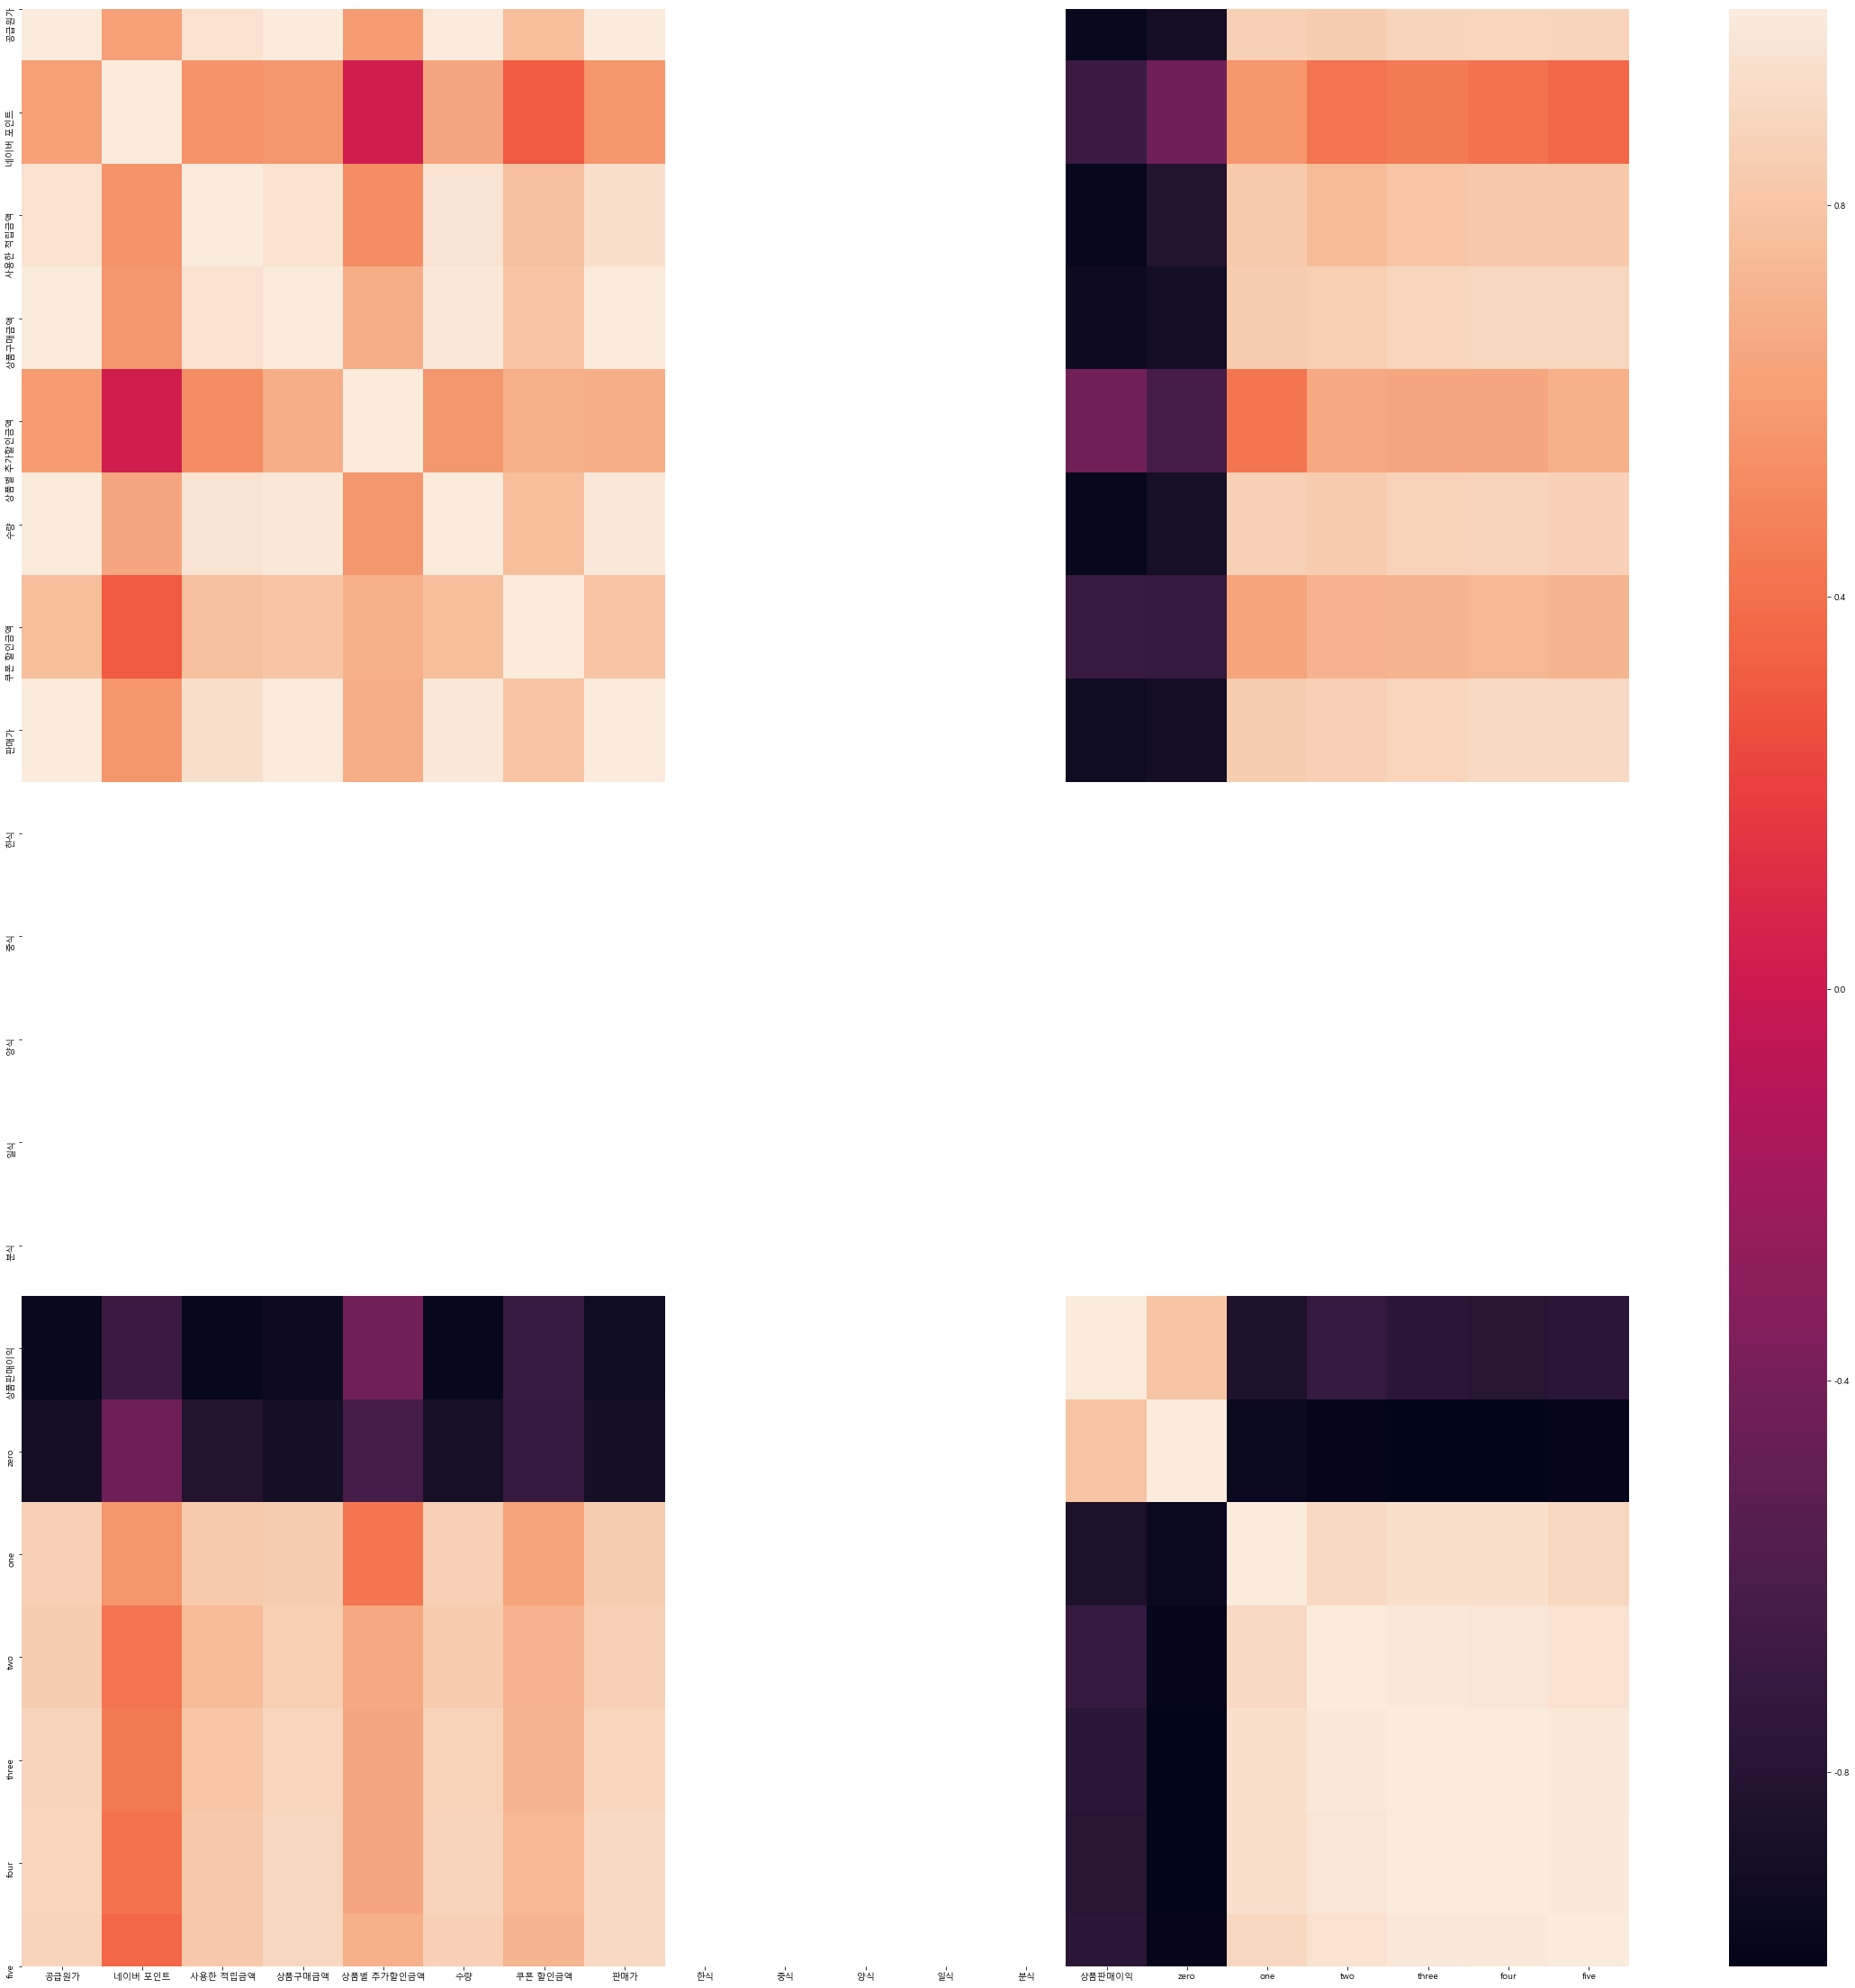

In [6]:

###########################           주문년월 별 데이터        ############################################
###########################  merge product data to order data   ############################################
pd_product_mid_category_sheet=pd.read_csv("./product_mid_category_sheet.csv")
df_order = pd.read_csv("order_preprocess_sheet.csv", engine='python',encoding='utf-8-sig')


df_pro_lie = pd_product_mid_category_sheet[['상품명(기본)','상품코드','대분류','중분류']]
df_pro_lie.rename(columns={"상품코드":"상품번호"}, inplace=True)

 

df_order_final = pd.merge(df_order,df_pro_lie,on='상품번호',how='inner')

print(df_order_final.head())

############################## 명목형 변수 더미화 #########################################


ls_menu=["한식","중식","양식","일식","분식"]  #더미화 column의 변수 리스트
ls_cat=[[] for i in range(len(ls_menu))]     #더미변수 값을 저장할 리스트 size= 1* 더비변수 갯수

#더미변수의 값 ls_cat에 저장 
for i in df_order_final['중분류']:  
    for j in range(len(ls_menu)):
        if ls_menu[j] in ls_cat: 
            ls_cat[j].append(1)
        else : 
            ls_cat[j].append(0)

#ls_cat값 df_order_final에 저장
for i in range(len(ls_menu)):
    df_order_final[ls_menu[i]]=ls_cat[i]

#주문년월로 그룹바이 
df_order_month = df_order_final[['공급원가', '네이버 포인트', '사용한 적립금액', '상품구매금액',
       '상품별 추가할인금액', '수량', '쿠폰 할인금액', '판매가','주문년월',"한식","중식","양식","일식","분식"]].groupby('주문년월').sum()

# 상품 판매이익 값 저장
df_order_month["상품판매이익"] = df_order_month["상품구매금액"]-df_order_month["공급원가"]*df_order_month["수량"]

###########################  open quater grade data  ############################################

df_quart_grade=pd.read_csv("./client_quart_grade_sheet.csv")
df_quart_grade.head()

# 분기별 등급별 고객수 
df_quart_grade_sum=pd.DataFrame(["zero","one","two","three","four","five"],columns=["grade"])
for i,col in enumerate(df_quart_grade.columns) :
    if i>1:
        df_quart_grade_sum[col]=df_quart_grade[col].value_counts()
cols=df_quart_grade_sum.columns[1:]

col_lst=df_quart_grade_sum.pivot(columns="grade",values=cols).columns
df_series=df_quart_grade_sum.pivot(columns="grade",values=cols).sum(axis=0)

garde_val_list=[] # 분기별(등급별) 데이터 저장 리스트
for val in df_series:
    garde_val_list.append(val)


############################## 등급 값 저장 분기->월 ##################################################
ls_grade_col=["zero","one","two","three","four","five"] #등급 칼럼
# 각 칼럼 생성 및 0으로 초기화
for col in ls_grade_col:
    df_order_month[col]=0
#
for i in range(10):
    for j in range(3):
        df_order_month.iloc[3*i+j,14]=int(garde_val_list[i*6+5])
        df_order_month.iloc[3*i+j,15]=int(garde_val_list[i*6+2])
        df_order_month.iloc[3*i+j,16]=int(garde_val_list[i*6+4])
        df_order_month.iloc[3*i+j,17]=int(garde_val_list[i*6+3])
        df_order_month.iloc[3*i+j,18]=int(garde_val_list[i*6+1])
        df_order_month.iloc[3*i+j,19]=int(garde_val_list[i*6+0])
        
#df_order_month.to_csv("./df_order_month.csv")
print(df_order_month)
plt.figure(figsize=(40,40))
print(df_order_month.corr())
sns.heatmap(df_order_month.corr())